# Original Spiker 

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimulationParameters, OptimizationParameters, ConstantCurrentInjection
from act.cell_model import TargetCell
from act.module_parameters import ModuleParameters

random_seed = 42
num_slices = 10

experiment_folder = f"output/Spiker_Original_sl-{num_slices}/{random_seed}"
target_folder = experiment_folder + "/target"
final_folder = experiment_folder + "/final"

target_cell = TargetCell(
    path_to_hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/orig/template.hoc",
    path_to_mod_files="/home/mwsrgf/proj/ACT/data/Spiker/orig/modfiles",
    cell_name="Spiker",
    active_channels = ["gnabar_hh_spiker", "gkbar_hh_spiker", "gl_hh_spiker"]
)

sim_par= SimulationParameters(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,        # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI = [ConstantCurrentInjection(amp=0.1,dur=300,delay=100, lto_hto=0),
                  ConstantCurrentInjection(amp=0.2,dur=300,delay=100, lto_hto=0),
                  ConstantCurrentInjection(amp=0.3,dur=300,delay=100, lto_hto=0)],
            set_g_to=[]
        )

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=target_folder,
        cell= target_cell,
        sim_params= sim_par
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.



        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/home/mwsrgf/proj/ACT/experiments/Spiker/not-filtered/output/Spiker_Original_sl-10/42/target/synthetic_0.1_0.2_0.3


# Ion Channel Range Randomizer

In [2]:
import random

random.seed(random_seed)

glbar_leak = 0.0003
gbar_na=0.12
gkdrbar_kdr=0.036

glbar_low_offset = random.uniform(0,glbar_leak/2)
na_low_offset = random.uniform(0,gbar_na/2)
kdr_low_offset = random.uniform(0,gkdrbar_kdr/2)

glbar_low = glbar_leak - glbar_low_offset
glbar_high = glbar_leak + ((glbar_leak/2) - glbar_low_offset)

na_low = gbar_na - na_low_offset
na_high = gbar_na + ((gbar_na/2) - na_low_offset)

kdr_low = gkdrbar_kdr - kdr_low_offset
kdr_high = gkdrbar_kdr + ((gkdrbar_kdr/2) - kdr_low_offset)



print(f"glbar: ({glbar_low},{glbar_high}) -- TRUE: {glbar_leak}")
print(f"na: ({na_low},{na_high}) -- TRUE: {gbar_na}")
print(f"kdr: ({kdr_low},{kdr_high}) -- TRUE: {gkdrbar_kdr}")


print("-------------")
print("Range (high - low) ")
print(f"leak range: {glbar_high - glbar_low} -- 50% TRUE: {glbar_leak/2}")
print(f"na range: {na_high - na_low} -- 50% TRUE: {gbar_na/2}")
print(f"kdr range: {kdr_high - kdr_low} -- 50% TRUE: {gkdrbar_kdr/2}")


glbar: (0.0002040859802313174,0.0003540859802313174) -- TRUE: 0.0003
na: (0.11849935468663998,0.17849935468663997) -- TRUE: 0.12
kdr: (0.03104947226935585,0.049049472269355854) -- TRUE: 0.036
-------------
Range (high - low) 
leak range: 0.00015000000000000001 -- 50% TRUE: 0.00015
na range: 0.059999999999999984 -- 50% TRUE: 0.06
kdr range: 0.018000000000000002 -- 50% TRUE: 0.018


In [3]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, ConductanceOptions, FilterParameters
from act.cell_model import TrainCell

train_cell = TrainCell(
    path_to_hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/orig/template.hoc",
    path_to_mod_files="/home/mwsrgf/proj/ACT/data/Spiker/orig/modfiles",
    cell_name="Spiker",
    active_channels = ["gnabar_hh_spiker", "gkbar_hh_spiker", "gl_hh_spiker"]
)

mod = ACTModule(
    ModuleParameters(
        module_folder_name=final_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            conductance_options= [
                ConductanceOptions(variable_name="gnabar_hh_spiker", low=na_low, high=na_high, n_slices=num_slices),
                ConductanceOptions(variable_name="gkbar_hh_spiker", low=kdr_low, high=kdr_high, n_slices=num_slices),
                ConductanceOptions(variable_name="gl_hh_spiker", low=glbar_low, high=glbar_high, n_slices=num_slices),
                
            ],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "number_of_troughs", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            spike_threshold=0,
            filter_parameters=FilterParameters(
                saturation_threshold=-55,
                window_of_inspection=(120,400)
            ),
            first_n_spikes=20,
            random_state=random_seed,
            save_file=f"{final_folder}/results/saved_metrics.json"
        )
    )
)

In [4]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA

        ACTSimulator (2024)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
Getting Conductance Combinations From Preselected Ranges
/home/mwsrgf/proj/ACT/experiments/Spiker/not-filtered/output/Spiker_Original_sl-10/42/final/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Num Troughs', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough

In [5]:
mod.pickle_rf(mod.rf_model,f"{final_folder}/trained_rf.pkl")

# Results and Metrics

In [6]:
from act import ACTPlot
ACTPlot.plot_v_comparison(
    final_folder,
    predicted_g_data_file, 
    sim_par.CI,
    sim_par.h_dt
    )

ACTPlot.plot_fi_comparison(
    final_folder, 
    sim_par.CI
    )

In [7]:
from act.Metrics import Metrics

metrics = Metrics()

mean, stdev = metrics.save_interspike_interval_comparison(
    final_folder,
    predicted_g_data_file,
    sim_par.CI, 
    sim_par.h_dt,
    first_n_spikes=5,
    save_file=f"{final_folder}/results/saved_metrics.json"
)

'''
"gnabar_hh_orig" = 0.12
"gkbar_hh_orig"=0.036
"gl_hh_orig"=0.0003
'''

actual_g={"gnabar_hh_spiker": 0.12,"gkbar_hh_spiker": 0.036, "gl_hh_spiker": 0.0003}

    
metrics.save_prediction_g_mae(
    actual_g=actual_g,
    save_file=f"{final_folder}/results/saved_metrics.json"
)

metrics.save_feature_mae(
    final_folder,
    predicted_g_data_file,
    ["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats", "lto-hto_amplitude", "lto-hto_frequency"],
    sim_par.h_dt,
    first_n_spikes=5,
    CI_settings=sim_par.CI,
    save_file=f"{final_folder}/results/saved_metrics.json"
)


Interspike times (Target): [[15.8 15.5 15.5 15.5]
 [12.7 12.3 12.2 12.2]
 [11.3 10.8 10.7 10.7]]
Interspike times (Prediction): [[15.7 15.5 15.4 15.5]
 [12.7 12.2 12.2 12.2]
 [11.3 10.7 10.8 10.7]]
MAE for each I injection: [0.05000000000000426, 0.02499999999999858, 0.05000000000000426]
Mean interspike-interval MAE: 0.04166666666666904
Standard Deviation interspike-interval MAE: 0.011785113019778472
MAE of final g prediction: 0.00016919502139338765
MAE of summary features for final prediction: 0.060180464029157194


Smallest MAE values (gnabar_hh_spiker, gkbar_hh_spiker, Summary Stats MAE): 
[[0.11849935 0.03504947 0.1856268 ]
 [0.12516602 0.03704947 0.26476016]
 [0.12516602 0.03704947 0.31681366]
 [0.12516602 0.03704947 0.33343431]
 [0.11849935 0.03504947 0.37700571]
 [0.11849935 0.03704947 0.44740862]]


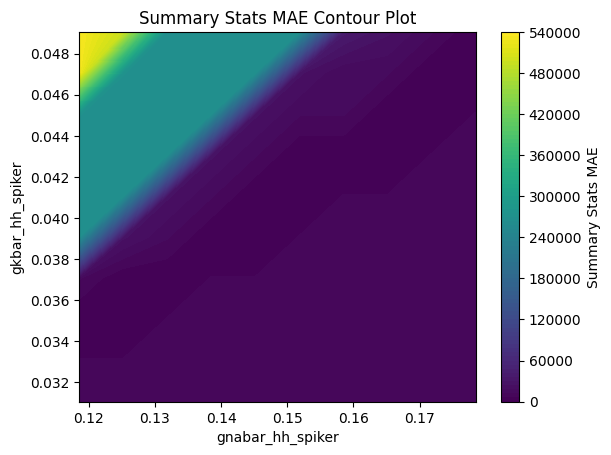

Smallest MAE values (gnabar_hh_spiker, gl_hh_spiker, Summary Stats MAE): 
[[1.18499355e-01 3.54085980e-04 1.85626802e-01]
 [1.25166021e-01 3.04085980e-04 2.64760161e-01]
 [1.25166021e-01 2.87419314e-04 3.16813663e-01]
 [1.25166021e-01 3.20752647e-04 3.33434314e-01]
 [1.18499355e-01 3.37419314e-04 3.77005711e-01]
 [1.18499355e-01 2.04085980e-04 4.47408625e-01]]


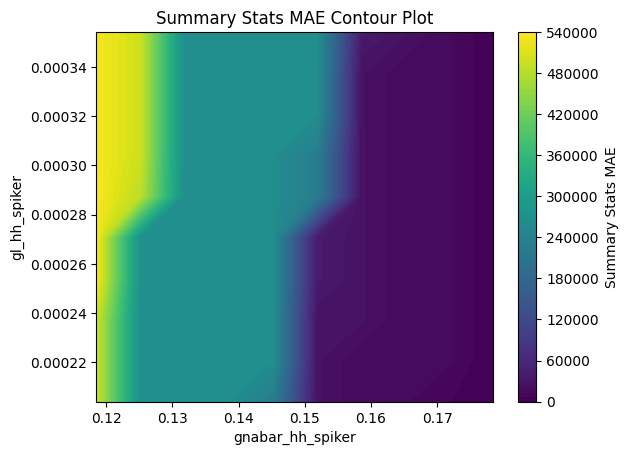

In [8]:
from act import ACTPlot as actplt

g_names = ["gnabar_hh_spiker", "gkbar_hh_spiker", "gl_hh_spiker"]

for i in range(len(g_names)-1):
    actplt.plot_training_feature_mae_contour_plot(
        final_folder,
        sim_par.CI,
        sim_par.CI[0].delay,
        sim_par.h_dt,
        index1=0,
        index2=i+1,
        g_names=g_names,
        train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats", "lto-hto_amplitude", "lto-hto_frequency"],
        threshold=0,
        first_n_spikes=20,
        num_levels=100,
        results_filename=f"{final_folder}/results/Feature_MAE_Contour_Plot_{g_names[0]}_{g_names[i+1]}.png"
    )

Smallest FI MAE values (gnabar_hh_spiker, gkbar_hh_spiker, FI MAE): 
[[0.16516602 0.04504947 0.        ]
 [0.12516602 0.03704947 0.        ]
 [0.12516602 0.03704947 0.        ]
 [0.12516602 0.03704947 0.        ]
 [0.12516602 0.03704947 0.        ]
 [0.12516602 0.03704947 0.        ]]


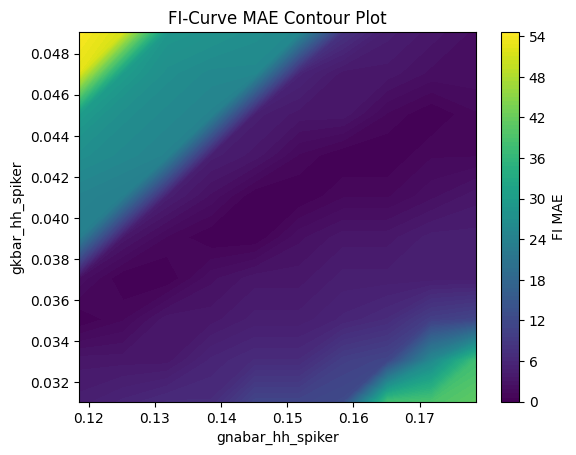

Smallest FI MAE values (gnabar_hh_spiker, gl_hh_spiker, FI MAE): 
[[0.16516602 0.00030409 0.        ]
 [0.12516602 0.00022075 0.        ]
 [0.12516602 0.00023742 0.        ]
 [0.12516602 0.00027075 0.        ]
 [0.12516602 0.00028742 0.        ]
 [0.12516602 0.00030409 0.        ]]


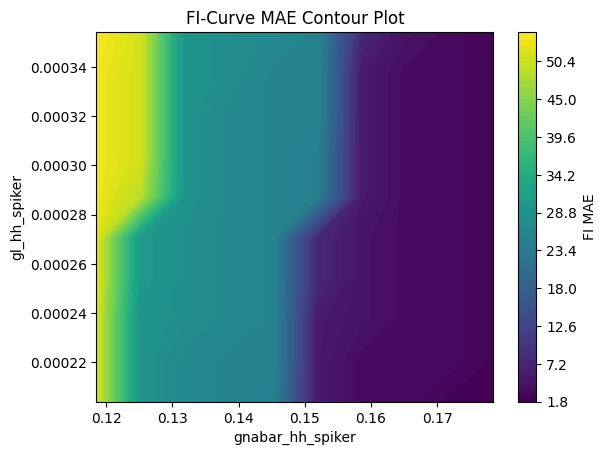

In [9]:
from act import ACTPlot as actplt

g_names = ["gnabar_hh_spiker", "gkbar_hh_spiker", "gl_hh_spiker"]

for i in range(len(g_names)-1):
    actplt.plot_training_fi_mae_contour_plot(
        final_folder,
        sim_par.CI, 
        sim_par.CI[0].dur,
        sim_par.CI[0].delay,
        sim_par.h_dt,
        index1=0,
        index2=i+1,
        g_names=g_names,
        results_filename=f"{final_folder}/results/FI_MAE_Contour_Plot_{g_names[0]}_{g_names[i+1]}.png"
    )

Smallest MAE values (gnabar_hh_spiker, gkbar_hh_spiker, V MAE): 
[[0.11849935 0.03504947 2.2512219 ]
 [0.12516602 0.03704947 2.94452776]
 [0.12516602 0.03704947 3.28756193]
 [0.12516602 0.03704947 3.69116396]
 [0.12516602 0.03704947 4.66563983]
 [0.11849935 0.03504947 4.96424764]]


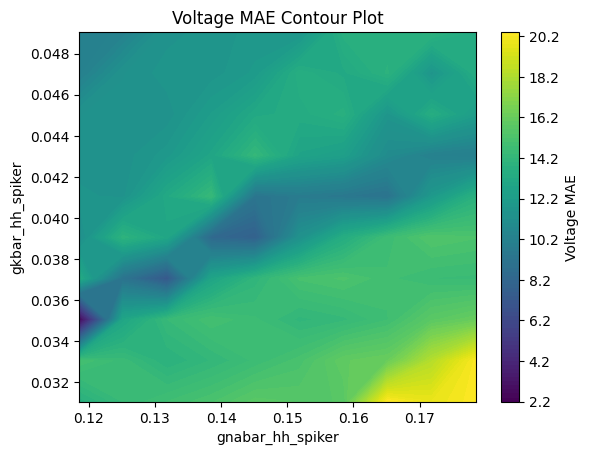

Smallest MAE values (gnabar_hh_spiker, gl_hh_spiker, V MAE): 
[[1.18499355e-01 3.54085980e-04 2.25122190e+00]
 [1.25166021e-01 2.87419314e-04 2.94452776e+00]
 [1.25166021e-01 3.04085980e-04 3.28756193e+00]
 [1.25166021e-01 2.70752647e-04 3.69116396e+00]
 [1.25166021e-01 3.20752647e-04 4.66563983e+00]
 [1.18499355e-01 3.37419314e-04 4.96424764e+00]]


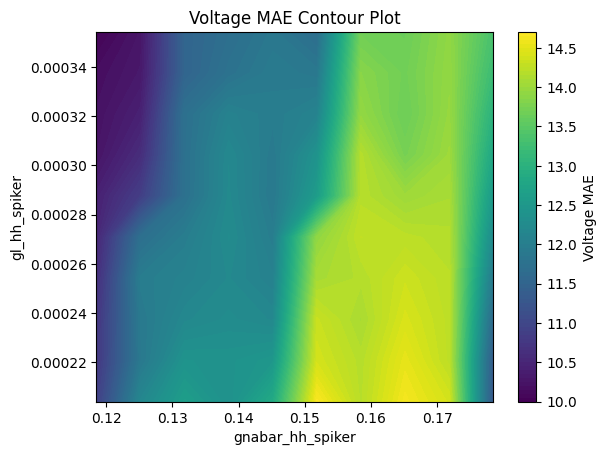

In [10]:
from act import ACTPlot as actplt

g_names = ["gnabar_hh_spiker", "gkbar_hh_spiker", "gl_hh_spiker"]


for i in range(len(g_names)-1):
    actplt.plot_training_v_mae_contour_plot(
        final_folder,
        sim_par.CI, 
        sim_par.CI[0].delay,
        sim_par.h_dt,
        index1=0,
        index2=i+1,
        g_names=g_names,
        results_filename=f"{final_folder}/results/Voltage_MAE_Contour_Plot_{g_names[0]}_{g_names[i+1]}.png"
    )